# Weather prediction in Australia

## Table of contents

1. Data preprocessing
   - 1.1. Cardinality of features
   - 1.2. Dealing with missing data
   - 1.3. Exploration of the dataset
   - 1.4. Dummy variables for the categorical features
2. Random forest
   - 2.1. First prediction and results
   - 2.2. Feature selection
   - 2.3. Comparison after feature selection : shall we include categorical (dummy) variables
   - 2.4. How many features to keep for feature selection ?
   - 2.5. Threshold rate for the random forest
3. Logistic regression
   - 3.1. First prediction with all the features and results
   - 3.2. Feature selection, using recursive feature elimination (RFE)
   - 3.3. Prediction after feature selection and results
4. Comparison between random forest and logistic regression

# Introduction

**Dataset**

The Dataset used is the ***Rain in Australia*** dataset on Kaggle, you can find it [here](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). This dataset contains about 10 years of daily weather observations from numerous Australian weather stations.

*RainTomorrow* is the target variable to predict. It means : did it rain the next day, "yes" or "no" ? The value in this column is "yes" if there was at least 1 mm of rain for that day.

The rest of the dataset is a mixture of categorical and numerical values. For a detailed explanation of the rest of the variables, please follow the link to the dataset.


**Objective**

We aim at building a classification model that can predict the target variable *RainTomorrow* with a high degree of accuracy. To do so, we will compare two machine learning methods.

Please note that this project was only created to help me try and improve my data science skills.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read the data

path = "C:/Users/Jarod/Documents/Data science/weatherAUS.csv"
rain_data = pd.read_csv(path, delimiter = ',')
rain_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# 1. Data preprocessing

## 1.1. Cardinality of features

It is generally considered a good idea to check the **cardinality** of **categorical features**. Indeed, if we face a categorical feature with high cardinality, one-hot encoding will not be worth considering.

In [3]:
# getting categorical features
CatFeatures = [column_name for column_name in rain_data.columns if rain_data[column_name].dtype == "O"]

for category in CatFeatures:
    count = len(rain_data[category].unique())
    print(f"the cardinality of the column {category} is {count}")

the cardinality of the column Date is 3436
the cardinality of the column Location is 49
the cardinality of the column WindGustDir is 17
the cardinality of the column WindDir9am is 17
the cardinality of the column WindDir3pm is 17
the cardinality of the column RainToday is 3
the cardinality of the column RainTomorrow is 3


As we can see, the cardinality for the column *Date* is a matter of concern. We shall deal with this by converting the column *Date* into three new **numerical** columns : *Year*, *Day*, and *Month*.

In [4]:
# check the data type of our date column
rain_data['Date'].dtype

dtype('O')

Checking the [numpy documentation](https://numpy.org/doc/stable/reference/arrays.dtypes.html) to match the letter code to the dtype of the object, we see that "O" is the code for "object". Therefore we need to parse dates first.

In [5]:
# parse dates
rain_data['Date'] = pd.to_datetime(rain_data['Date'], format="%Y-%m-%d")

# create the new columns
rain_data['Year'] = rain_data['Date'].dt.year
rain_data['Month'] = rain_data['Date'].dt.month
rain_data['Day'] = rain_data['Date'].dt.day

# then drop the 'Date' column
rain_data.drop("Date", axis = 1, inplace = True)

# and finally take a look at what the dataframe looks like now
rain_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        143975 non-null  float64
 2   MaxTemp        144199 non-null  float64
 3   Rainfall       142199 non-null  float64
 4   Evaporation    82670 non-null   float64
 5   Sunshine       75625 non-null   float64
 6   WindGustDir    135134 non-null  object 
 7   WindGustSpeed  135197 non-null  float64
 8   WindDir9am     134894 non-null  object 
 9   WindDir3pm     141232 non-null  object 
 10  WindSpeed9am   143693 non-null  float64
 11  WindSpeed3pm   142398 non-null  float64
 12  Humidity9am    142806 non-null  float64
 13  Humidity3pm    140953 non-null  float64
 14  Pressure9am    130395 non-null  float64
 15  Pressure3pm    130432 non-null  float64
 16  Cloud9am       89572 non-null   float64
 17  Cloud3pm       86102 non-null

Finally, we update the **categorical** features, and get the **numerical** ones.

In [6]:
# getting categorical features
CatFeatures = [column_name for column_name in rain_data.columns if rain_data[column_name].dtype == "O"]

# getting numerical features
NumFeatures = [column_name for column_name in rain_data.columns if rain_data[column_name].dtype != "O"]

## 1.2. Dealing with missing data

<AxesSubplot:>

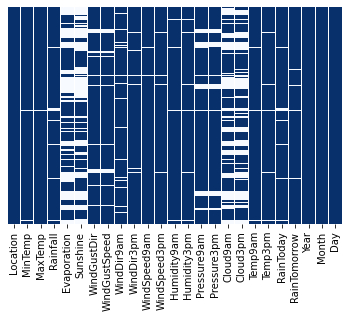

In [7]:
# Visualisation of missing data
# heatmap where a missing piece of data appears as a white line, and a present one is a blue line.

sns.heatmap(rain_data.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='Blues_r'
           )

### 1.2.1. Categorical features

Now that we dealt with cardinality, it is also important to get any null values that may exist out of the way before moving on to data preparation. We begin by filling in missing values for **categorical** variables.

In [8]:
# total number of NAs for each categorical feature
rain_data[CatFeatures].isnull().sum()

Location            0
WindGustDir     10326
WindDir9am      10566
WindDir3pm       4228
RainToday        3261
RainTomorrow     3267
dtype: int64

As all the locations are provided, we can immediately move on to the three features about wind. We may imagine that when there is a null value, it means that there was no wind during the day, hence the need to **create a new category** for this.

In [9]:
# dictionary to fill NA values
fill_dictionary = {
    'WindGustDir' : "no",
    'WindDir9am' : "no",
    'WindDir3pm' : "no",  
}

for key, value in fill_dictionary.items():
  rain_data[key] = rain_data[key].fillna(value)

Then, for the features *RainToday* and *RainTomorrow*, it would appear strange to fill missing values with any method before training on these guessed values. It is probably better to **drop the rows** with NA values, which will be done after dealing with numerical values.

### 1.2.2. Numerical features

Next, we need to deal with the null values for **numerical** variables. However, this is a bit more complicated than with categorical values : we first need to check for **outliers**. This is an important step because outliers can distort the statistical parameters (e.g. the mean or the median) of our dataset. This means that after imputing our distorted statistical measure, our dataset becomes irrepresentative of the population it is supposed to be representative of.

However, there are also drawbacks to removing outliers. For this specific dataset, when thinking about weather, it is important to note that extreme events such as rainstorms and drought that might be helpful in predicting *RainTomorrow* for those specific time periods will be marked outlying events through our analysis.

In this specific situation, the benefit of removing outliers far outweighs the cost : for a relatively small dataset such as this one, we can not afford to just delete missing cells from the dataset. However, a more sophisticated analysis of weather in Australia with more available data would stop here and handle the missing values using a different methodology (and, most likely, have a better accuracy rate as a result).

In [10]:
# total number of NAs for each numerical feature
rain_data[NumFeatures].isnull().sum()

MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
Year                 0
Month                0
Day                  0
dtype: int64

In [11]:
# get the variables which actually have null/missing values
NumFeaturesWithNA = [column for column in NumFeatures if rain_data[column].isnull().sum()]
NbrNumFeaturesWithNA = rain_data[NumFeaturesWithNA].isnull().sum()
# now we have only those with missing values
NbrNumFeaturesWithNA

MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
dtype: int64

<AxesSubplot:>

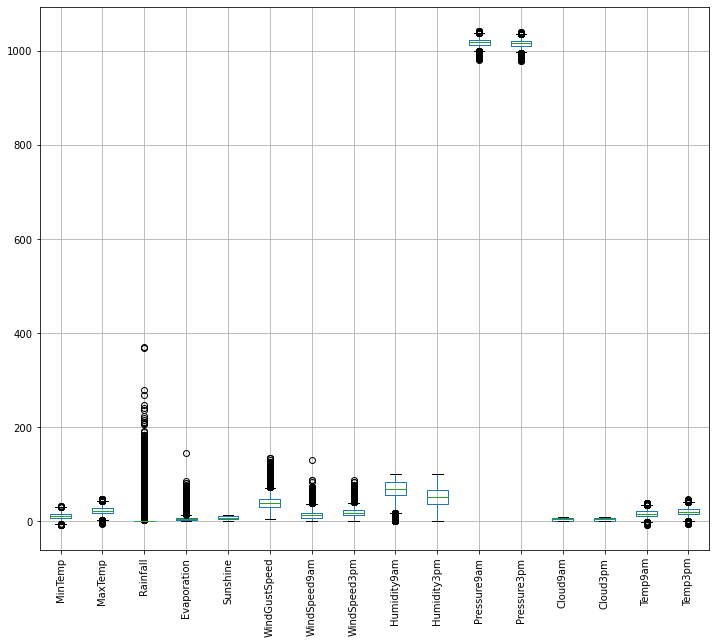

In [12]:
# check for outliers
plt.figure(figsize=(12,10))
rain_data.boxplot(NumFeaturesWithNA,rot=90)

This boxplot shows that there are **outliers**. We will handle them using the **IQR (interquartile range)** method.

This is a drawback of filling in missing values. As explained before, outliers can sometimes provide important information about the data. For instance, we have a lot of outliers for *Rainfall*, which is obviously linked with what we are trying to predict : this means we might have trouble predicting rain for "outlying" events later on. 

In [13]:
# remove outliers
for feature in NumFeaturesWithNA:
    q1 = rain_data[feature].quantile(0.25)
    q3 = rain_data[feature].quantile(0.75)
    IQR = q3-q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    rain_data.loc[rain_data[feature]<lower_limit,feature] = lower_limit
    rain_data.loc[rain_data[feature]>upper_limit,feature] = upper_limit

Now that we have removed outliers, we can handle **missing values**. We choose to fill them with the mean, since these missing values probably do not have a proper significance and are just a lack in the dataset.

In [14]:
# fill in missing cells with the mean 
for features in NumFeaturesWithNA:
    rain_data[features] = rain_data[features].fillna(rain_data[features].mean())

# make sure that worked:
rain_data[NumFeaturesWithNA].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

Next, we will remove the *Location* feature since it will be hard for our algorithm to exploit.

Finally, we turn the columns *RainToday* and *RainTomorrow* to **numerical** by replacing "No" by 0 and "Yes" by 1.

In [15]:
# Remove column 'Location'
rain_data.drop(['Location'],axis=1,inplace=True)

# Drop rows with null values
rain_data.dropna(inplace=True)

# Replace 'Yes' by 1 and 'No' by 0 in the 'RainToday' and 'RainTomorrow' features
rain_data[['RainTomorrow','RainToday']] = rain_data[['RainTomorrow','RainToday']].replace({'No':0,'Yes':1})

## 1.3. Exploration of the dataset

0    109586
1     31201
Name: RainTomorrow, dtype: int64


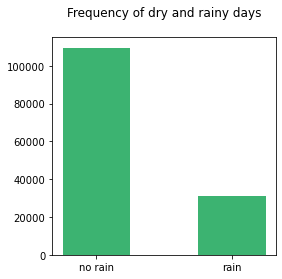

In [16]:
# Frequency of dry and rainy days

plt.figure(figsize=(4,4))
plt.hist(rain_data['RainTomorrow'],bins=2,rwidth=.5,color='mediumseagreen')
plt.xticks([.25,.75],['no rain','rain'])
plt.title('Frequency of dry and rainy days\n')
print(rain_data['RainTomorrow'].value_counts())

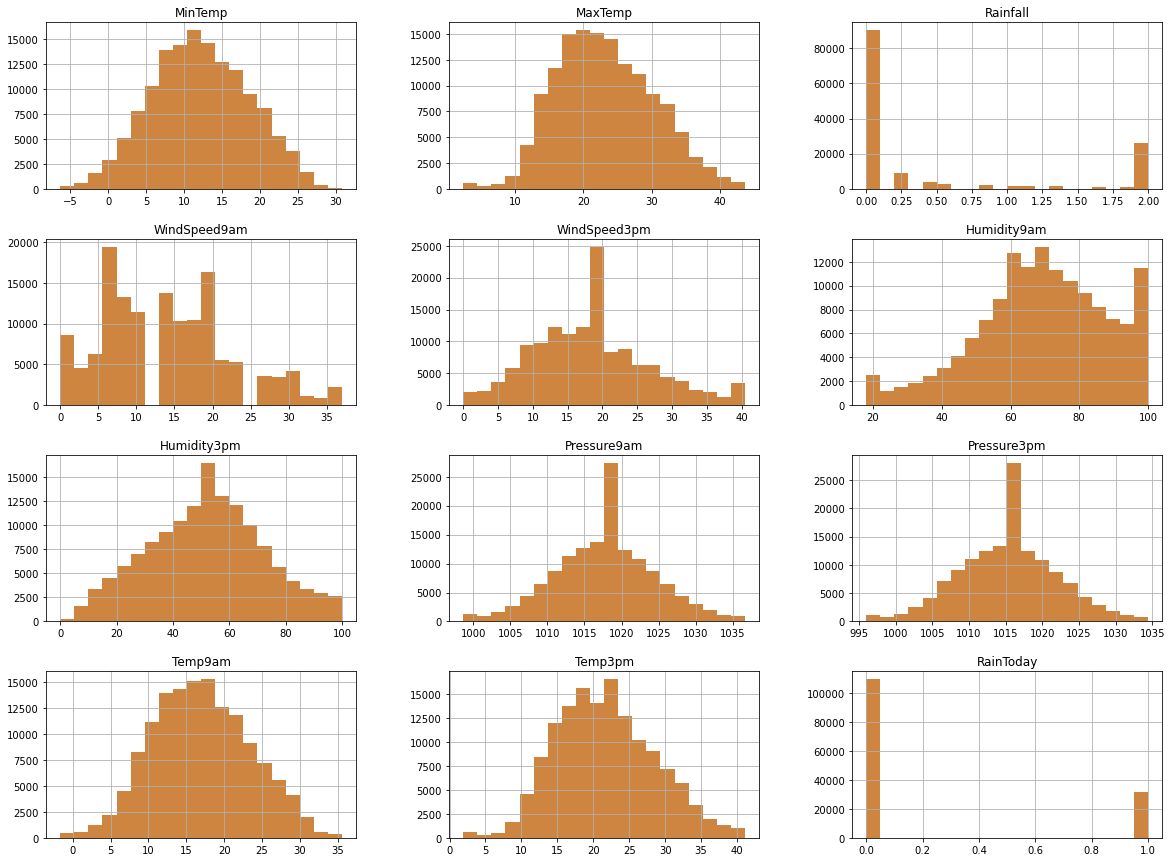

In [17]:
# Histograms for the numerical features

# Separate numerical features from categorical ones
rain_data_num = rain_data[['MinTemp','MaxTemp','Rainfall','WindSpeed9am','WindSpeed3pm',
                           'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm',
                           'Temp9am','Temp3pm','RainToday','RainTomorrow']]

# Histogram of each numerical feature
ax_list = rain_data_num.drop(['RainTomorrow'],axis=1).hist(figsize=(20,15),bins=20,color='peru')

<AxesSubplot:>

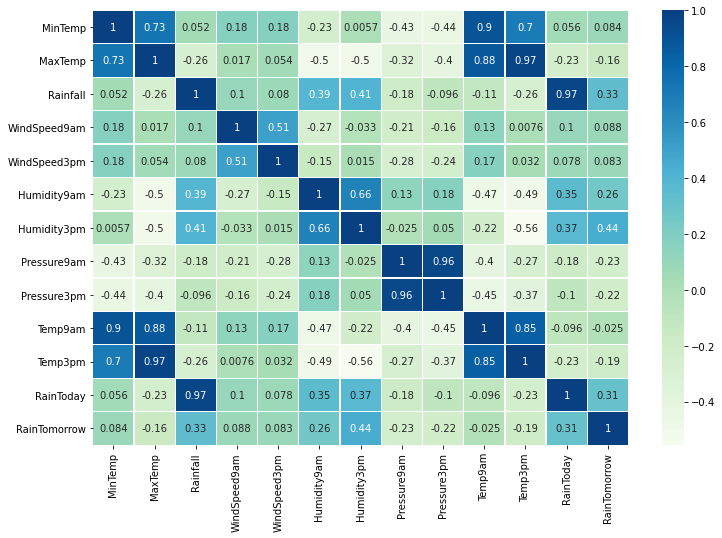

In [18]:
# Correlation matrix for the numerical features

plt.figure(figsize=(12,8))
sns.heatmap(rain_data_num.corr(),annot=True,cmap='GnBu',linewidths=0.25)

## 1.4. Dummy variables for the categorical features

In [19]:
# Create dummy variables for the categorical features:
WindGustDir_data = pd.get_dummies(rain_data['WindGustDir'])
WindDir9am_data = pd.get_dummies(rain_data['WindDir9am'])
WindDir3pm_data = pd.get_dummies(rain_data['WindDir3pm'])

# Dataframe of categorical features
rain_data_cat = pd.concat([WindGustDir_data,WindDir9am_data,WindDir3pm_data],
                          axis=1,keys=['WindGustDir','WindDir9am','WindDir3pm'])

# Combine the numerical and categorical/dummy variables
rain_data = pd.concat([rain_data_num,rain_data_cat],axis=1)

Finally, we split data into train and test datasets.

In [20]:
from sklearn.model_selection import train_test_split

X = rain_data.drop(['RainTomorrow'],axis=1)
y = rain_data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# 2. Random forest

## 2.1. First prediction and results

### 2.1.1. Fit and then predict with the classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators, or number of decision trees set to 100
rf = RandomForestClassifier(n_estimators=100,random_state=0)
rf.fit(X_train,y_train)
y_rf_pred = rf.predict(X_test)

### 2.1.2. Null accuracy

In [22]:
# "no rain" and "rain" frequencies in test set
print(y_test.value_counts())

null_accuracy = float(y_test.value_counts().head(1) / len(y_test))
print('Null Accuracy Score: {:.2%}'.format(null_accuracy))

0    21813
1     6345
Name: RainTomorrow, dtype: int64
Null Accuracy Score: 77.47%


If we build a model that guesses "no rain" every time, then we will obtain a **null accuracy** (or **baseline accuracy**) of 77.47%. This value will be helpful to realize how accurate the random forest performed.

### 2.1.3. Random forest result

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
print('Accuracy Score: {:.2%}'.format(accuracy_score(y_test,y_rf_pred),'\n'))
print('Confusion Matrix:\n',confusion_matrix(y_test,y_rf_pred))

Accuracy Score: 84.35%
Confusion Matrix:
 [[20851   962]
 [ 3444  2901]]


Accuracy rate is 84.35%, however the baseline accuracy is 77.47%. There are more false negatives (3,444) than true negatives (962) --- i.e. a lot of type II errors. Let's try to make our model simpler through **feature selection**, as there are 60 features. Then we will try and **improve the true positive rate** (cf. 2.5.4).

## 2.2. Feature selection

In this subsection, we try to determine which features add value to the prediction. **Feature selection** (reducing the number of variables) will make our model simpler and reduce the chances of overfitting. We don't want to use variables that don't have much value when we train our model to predict out-of-sample data.

In [24]:
# We use feature_importances_ for feature selection
feature_importance_rf = pd.DataFrame(rf.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values(['Importance'],ascending=False)
feature_importance_rf.head(5)

,Importance
Humidity3pm,0.176943
Pressure3pm,0.076692
Pressure9am,0.072043
Humidity9am,0.068856
Temp3pm,0.067575


<AxesSubplot:>

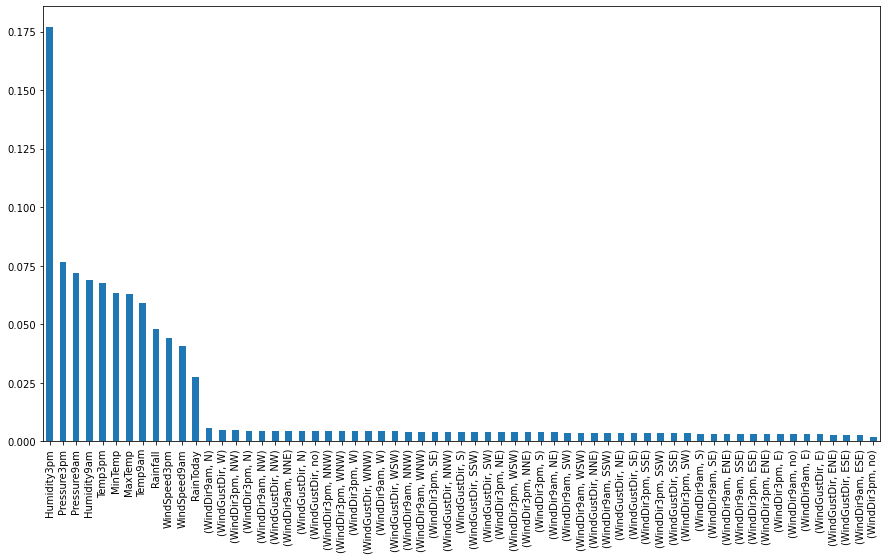

In [25]:
# Plot of feature_importance for the random forest
feature_importance_rf.plot(kind='bar',legend=False,figsize=(15,8))

Remember our categorical variables : *WindGustDir*, *WindDir9am* and *WindDir3pm*, were transformed into **dummy variables** to make the random forest algorithm perform better. Because they were transformed into dummy variables, then they would appear to rank low under the important features, as plotted above.

To see whether the categorical (dummy) variables add much value to our model, we will compute the accuracy rate for the random forest using only the top 5 features, and compare it with the accuracy rate for the random forest using the top 5 features as well as the categorical variables.

## 2.3. Comparison after feature selection : shall we include categorical (dummy) variables ?

### 2.3.1. Random forest with only the top 5 features

In [26]:
# Our top 5 features
features_top_5 = list(feature_importance_rf.index[0:6])

# X dataframe - with only the top 5 features
subset_1 = [X.columns.get_loc(x) for x in features_top_5]

# split, train and predict
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,subset_1], y, test_size=.2, random_state=0)
rf.fit(X_train,y_train)
y_rf_pred = rf.predict(X_test)

print('Accuracy Score: {:.2%}'.format(accuracy_score(y_test,y_rf_pred)))
print('Confusion Matrix:\n',confusion_matrix(y_test,y_rf_pred))

Accuracy Score: 83.66%
Confusion Matrix:
 [[20715  1098]
 [ 3502  2843]]


### 2.3.2. Random forest with the top 5 features and categorical (dummy) variables

In [27]:
# X dataframe - with top 5 features and the categorical variables
subset_2 = subset_1 + list(range(12,len(X.columns)))

# split, train and predict
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,subset_2], y, test_size=.2, random_state=0)
rf.fit(X_train,y_train)
y_rf_pred = rf.predict(X_test)

print('Accuracy Score: {:.2%}'.format(accuracy_score(y_test,y_rf_pred)))
print('Confusion Matrix:\n',confusion_matrix(y_test,y_rf_pred))

Accuracy Score: 83.97%
Confusion Matrix:
 [[20853   960]
 [ 3555  2790]]


### 2.3.3. Conclusion

From here we can conclude that the categorical features do not add a significant value to the accuracy rate. Therefore we can remove the categorical (dummy) features.

## 2.4. How many features to keep for feature selection ? 

Generally speaking, there is no right answer to this question. To help us choose a number of features to use, let's visualise the relationship between the **number of features used**, and the **accuracy rate**.

### 2.4.1. Making a choice and generating predictions

In [28]:
%%time 

# up to what number of features to plot
index = np.array(list(range(2,11, 2)) + [15, 30, 60])

# create list of index locations
features = list(feature_importance_rf.index) # list of features ordered by importance (decreasingly)
features = [X.columns.get_loc(x) for x in features]

# instantiate classifier
rf = RandomForestClassifier(n_estimators=100,random_state=0)

accuracy_rate = []

# append the accuracy rate
for i in index:
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,features[0:i]], y, test_size=.2, random_state=0)
    rf.fit(X_train,y_train)
    y_rf_pred = rf.predict(X_test)    
    accuracy_rate.append(accuracy_score(y_test,y_rf_pred))

Wall time: 32min 45s


Text(0.5, 1.0, 'Random forest \nAccuracy rate vs. number of features')

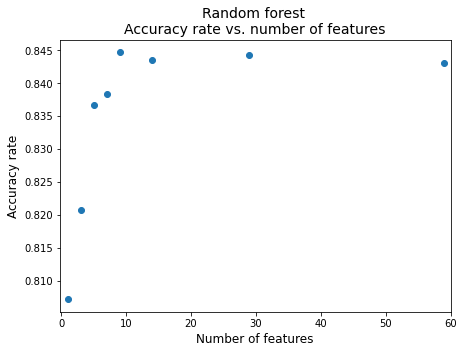

In [29]:
# Plot of accuracy in function of number of features
plt.figure(figsize=(7,5))
plt.scatter(x=index-1,y=accuracy_rate)
plt.ylabel('Accuracy rate',fontsize=12)
plt.xlabel('Number of features',fontsize=12)
plt.xlim(-.2,60)
plt.title('Random forest \nAccuracy rate vs. number of features', fontsize = 14)

We can see that there is not much improvement to the accuracy rate when the number of features is 10 or more. To keep our model simple, we will use 10 features instead of 60. The accuracy rates from 10 to 60 features differ by only 0.12%.

In [30]:
# split, train and predict on the top 10 features
X_train, X_test, y_train, y_test = train_test_split(X[feature_importance_rf.head(10).index], y, test_size=.2, random_state=0)
rf.fit(X_train,y_train)
y_rf_pred = rf.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test,y_rf_pred), index=['NO RAIN','RAIN'],columns=['NO RAIN','RAIN'])

### 2.4.2. Confusion matrix for our selected-features random forest model

Accuracy score (top 10 features): 84.47% 



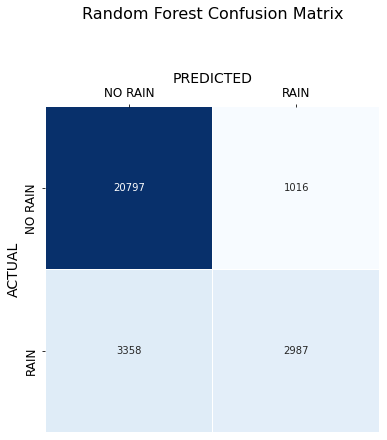

In [31]:
print('Accuracy score (top 10 features): {:.2%}'.format(accuracy_score(y_test,y_rf_pred)),'\n')

# plot confusion matrix
fig = plt.figure(figsize=(6,6))
ax = sns.heatmap(cm,annot=True,cbar=False,cmap='Blues',linewidths=.5,fmt='.0f')
ax.set_title('Random Forest Confusion Matrix',fontsize=16,y=1.25)
ax.set_ylabel('ACTUAL',fontsize=14)
ax.set_xlabel('PREDICTED',fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)

Let's have a look at **sensitivity** and **specifity**.

**Sensitivity** : When it rains, how often are our predictions correct?
**Specificity** : When it does not rain, how often are our predictions correct?

Of course, as it does not rain about 77% of the time, we expect the specificity rate to be higher.

In [32]:
TP = cm.iloc[1,1] # True Positive, i.e. predicted "rain" correctly
TN = cm.iloc[0,0] # True Negative, i.e. predicted "no rain" correctly
FP = cm.iloc[0,1] # False Positive, i.e. predicted "rain" when it did not rain
FN = cm.iloc[1,0] # False Negative, i.e. predicted "no rain" when it rained

sens_rf = TP/(FN+TP)
spec_rf = TN/(FP+TN)

In [33]:
print('Sensitivity: {:.2%}'.format(sens_rf))
print('Specificity: {:.2%}'.format(spec_rf))

Sensitivity: 47.08%
Specificity: 95.34%


To sum up : when it rained, we correctly predicted "rain" 47.08% of the time, whereas when it did not rain, we correctly predicted "no rain" 95.34% of the time.

## 2.5. Threshold rate for the random forest

### 2.5.1. Definition and motivation

The random forest algorithm produces a probability score (the proportion of votes of the trees in the ensemble) in order to make classification. Let's visualise the probability scores for "rain" and "no rain".

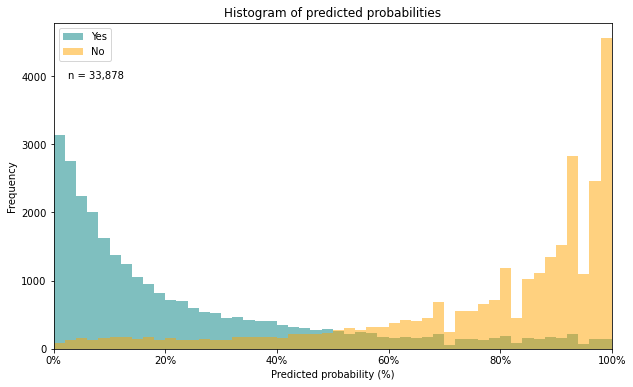

In [34]:
# proves np.array of the probability scores
y_prob_rain = rf.predict_proba(X_test)

# convert x-axis to a percentage
from matplotlib.ticker import PercentFormatter

# Plot histogram of predicted probabilities
fig,ax = plt.subplots(figsize=(10,6))
plt.hist(y_prob_rain[:,1],bins=50,alpha=.5,color='teal',label="Yes") #label rain
plt.hist(y_prob_rain[:,0],bins=50,alpha=.5,color='orange',label="No") #label no rain
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability (%)')
plt.ylabel('Frequency')

ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.text(.025,.83,'n = 33,878',transform=ax.transAxes)

plt.legend()

The random forest classication model uses 50% as the **threshold rate** for classification. It means that if the prediction probability of "rain" is higher than 50%, it will predict "rain" ; else, if the probability of "rain" is lower than 50%, then it will predict "no rain".

Because of the binary relationship between "rain" and "no rain", the histogram has the highest frequency at 0% for "rain" and at 100% for "no rain".

We may wonder whether the cost of a false negative is greater than a false positive. In other words, we may think it is more prejudicial to predict "no rain" when it rained, than to predict "rain" when it did not rain.

The 50% threshold can be reduced in order to increase the **sensitivity rate**. However this will reduce the **specificity rate** because there is an inverse relationship between **sensitivity** and **specificity**.


### 2.5.2. ROC Curve (true positive vs. false positive rate) and threshold curve for the random forest model

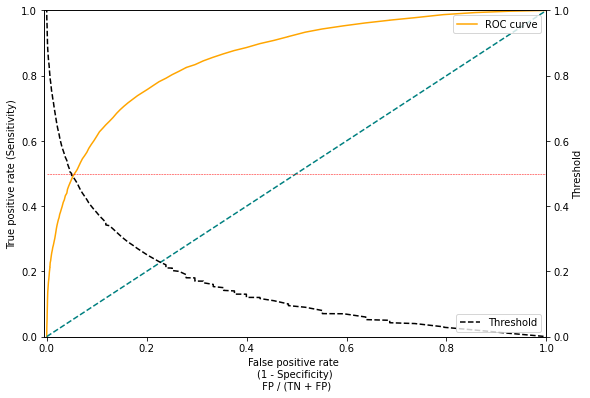

In [35]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_test,y_prob_rain[:,1])

fig,ax1 = plt.subplots(figsize=(9,6))
ax1.plot(fpr, tpr,color='orange')
ax1.legend(['ROC curve'],loc=1)
ax1.set_xlim([-0.005, 1.0])
ax1.set_ylim([0,1])
ax1.set_ylabel('True positive rate (Sensitivity)')
ax1.set_xlabel('False positive rate \n(1 - Specificity)\n FP / (TN + FP)')
#ax1.set_title('ROC curve for "RainTomorrow" random forest classifier\n')

plt.plot([0,1],[0,1],linestyle='--',color='teal')
plt.plot([0,1],[0.5,0.5],linestyle='--',color='red',linewidth=.5)

#Threshold curve
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='black')
ax2.legend(['Threshold'],loc=4)
ax2.set_ylabel('Threshold',color='black')
ax2.set_ylim([0,1])
ax2.grid(False)

The default threshold is 50%, which had resulted in a low sensitivity rate of 47.08% and a specificity rate of 95.34%. Now we will change the threshold so that it provides a **higher sensitivity rate** at the cost of a **lower specificity rate**.

### 2.5.3. Selection of the threshold rate

In [36]:
# function to compute sensitivity and specificity rate for a given threshold
def evaluate_threshold(threshold):
    print('Sensitivity: {:.2%}'.format(tpr[thresholds > threshold][-1]))
    print('Specificity: {:.2%}'.format(1 - fpr[thresholds > threshold][-1]))

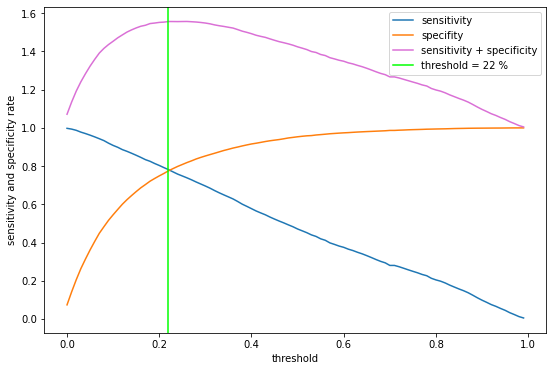

In [37]:
chosen_threshold=.22 # new threshold rate

def evaluate_sensitivity(threshold):
    return tpr[thresholds > threshold][-1] # sensitivity rate

def evaluate_specificity(threshold):
    return 1 - fpr[thresholds > threshold][-1] # specificity rate

plt.figure(figsize=(9,6))
threshold_candidates = np.arange(0., 1., 0.01)
sensitivities = []
for thr in threshold_candidates:
    sensitivities.append(evaluate_sensitivity(thr))
plt.plot(threshold_candidates, sensitivities)
specificities = []
for thr in threshold_candidates:
    specificities.append(evaluate_specificity(thr))
plt.plot(threshold_candidates, specificities)
SensPlusSpec = []
for i in range(0,100):
    SensPlusSpec.append(sensitivities[i]+specificities[i])
plt.plot(threshold_candidates,SensPlusSpec,color='orchid')
plt.axvline(x=chosen_threshold,color='lime')
plt.xlabel("threshold")
plt.ylabel("sensitivity and specificity rate")
plt.legend(["sensitivity","specifity","sensitivity + specificity", "threshold = 22 %"])

We will reduce the threshold from 50% to 22%. Thus, if in our random forest, the probability of "rain" is higher than 22%, the model will predict "rain" (for tomorrow). Conversely, if the probability of "rain" is lower than 22%, the model will predict "no rain".

### 2.5.4. Confusion matrix for our selected-features and selected-threshold rate random forest model

Accuracy score (top 10 features with 22% threshold): 77.67% 



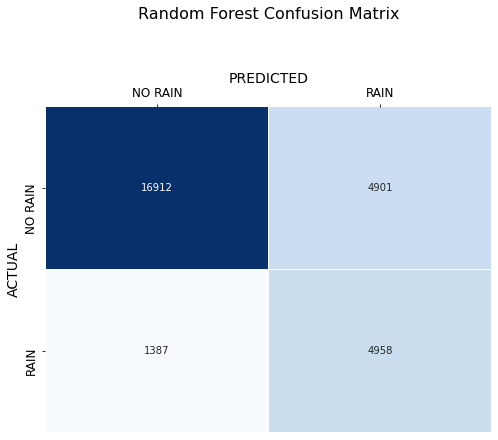

In [38]:
from sklearn.preprocessing import binarize
# change the predicted class with 22% threshold
y_pred_class = binarize(y_prob_rain,threshold=chosen_threshold)[:,1]

cm = pd.DataFrame(confusion_matrix(y_test,y_pred_class),index=['NO RAIN','RAIN'],columns=['NO RAIN','RAIN'])

print('Accuracy score (top 10 features with 22% threshold): {:.2%}'.format(accuracy_score(y_test,y_pred_class)),'\n')

# Plot confusion Matrix
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(cm,annot=True,cbar=False, cmap='Blues',linewidths=.5,fmt='.0f')
ax.set_title('Random Forest Confusion Matrix',fontsize=16,y=1.25)
ax.set_ylabel('ACTUAL',fontsize=14)
ax.set_xlabel('PREDICTED',fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)

In [39]:
TP = cm.iloc[1,1] # True Positive - Predicted Rain Correctly
TN = cm.iloc[0,0] # True Negative - Predicted No Rain Incorrectly
FP = cm.iloc[0,1] # False Positive - Predicted Rain when it didn't rain
FN = cm.iloc[1,0] # False Negative - Predicted No Rain when it did rain

sens_rf_2 = TP/(FN+TP)
spec_rf_2 = TN/(FP+TN)

print('Sensitivity: {:.2%}'.format(sens_rf_2))
print('Specificity: {:.2%}'.format(spec_rf_2))

Sensitivity: 78.14%
Specificity: 77.53%


As we can see, this makes our **accuracy decrease**, thus we can conclude our assumption stating that *the cost of a false negative is greater than the one of a false positive* is **false**.

However, we witness the phenomenon we expected : the sensitivity rate increases while the specificity rate dwindles : when it rained, we correctly predicted "rain" 78.14% of the time, while when it did not rain, we correctly predicted "no rain" 77.53% of the time.

Next, we try to determine what is the **best threshold**, i.e. the threshold which gives the highest accuracy score.

In [40]:
chosen_thresholds = np.arange(.01, 1., .01)

# change the predicted class with 1% to 99% thresholds and get the accuracy scores

y_pred_class = np.zeros((len(chosen_thresholds), len(y_prob_rain)))
AccuracyScores = []
for i in range(len(chosen_thresholds)):
    y_pred_class[i,:] = binarize(y_prob_rain,threshold=chosen_thresholds[i])[:,1]
    AccuracyScores.append(accuracy_score(y_test,y_pred_class[i,:]))

# get threshold with highest accuracy score

BestThreshold = chosen_thresholds[AccuracyScores.index(max(AccuracyScores))]
print("Best threshold : {:.2%}".format(BestThreshold))

Best threshold : 49.00%


This shows we should not change threshold since 50 % is a very good choice. 

### 2.5.5. AUC for Random Forest

The AUC is the Area Under the ROC Curve. If the model produces a high sensitivity and specificity rate (which is what we would want to achieve), then the ROC curve will be stretched towards the top left of the x-y axis. The AUC provides an indication on how well the model performed in comparison to another model.

In [41]:
rf_auc = roc_auc_score(y_test,y_prob_rain[:,1])
print('AUC Score: {:.2%}'.format(rf_auc))

AUC Score: 85.90%


# 3. Logistic regression

## 3.1. Using all the features

First, let's train and predict with our logistic regression model using all the features of the dataset...

In [42]:
# Libraries for the Logistic Regression 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = rain_data.drop(['RainTomorrow'],axis=1)
y = rain_data['RainTomorrow']
# Remove the Categorical (Dummy) Variables, as we have identified earlier that they do not add much value
X = X.iloc[:,0:12] 


# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# Logistic Regression train
lr = LogisticRegression(random_state=0, solver='liblinear')
lr.fit(X_train,y_train)

# predict
y_lr_pred = lr.predict(X_test)

... and we get the following result.

In [43]:
# The 10-fold cross validation method is used to calculate the accuracy score of the logistic regression model.
print('Accuracy Score with 10 folds: {:.2%}'.format(cross_val_score(lr,X,y,cv=10,scoring='accuracy').mean()),'\n')
print('Confusion Matrix:\n',confusion_matrix(y_test,y_lr_pred))

Accuracy Score with 10 folds: 83.01% 

Confusion Matrix:
 [[20779  1034]
 [ 3722  2623]]


## 3.2. Feature selection, using recursive feature elimination (RFE)

As our final random forest model used 10 features, we will allow the same number of features for the logistic regression model.

In [44]:
%%time

# Feature selection method : recursive feature elimination 
rfe = RFE(estimator=lr,n_features_to_select=10)
rfe = rfe.fit(X_train,y_train)

print("Number of Features: {}".format(rfe.n_features_)) 
print("Selected Features: {}".format(rfe.support_))
print("Feature Ranking: {}".format(rfe.ranking_))

Number of Features: 10
Selected Features: [ True  True  True  True False False  True  True  True  True  True  True]
Feature Ranking: [1 1 1 1 2 3 1 1 1 1 1 1]
Wall time: 2.85 s


Finally, we get our selected features :

In [45]:
pd.DataFrame(X.iloc[:,rfe.support_].columns,columns=['Importance'])

,Importance
0,MinTemp
1,MaxTemp
2,Rainfall
3,WindSpeed9am
4,Humidity3pm
5,Pressure9am
6,Pressure3pm
7,Temp9am
8,Temp3pm
9,RainToday


## 3.3. After feature selection

In [46]:
# Predictions

X_rfe = X.iloc[:,rfe.support_]
# Train test split with subset of X features
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=.2, random_state=0)
# Fit and predict
lr.fit(X_train,y_train)
y_lr_pred = lr.predict(X_test)

In [47]:
# accuracy rate using 10 folds cross validation

accuracy_kfold = cross_val_score(lr,X_rfe,y,cv=10,scoring='accuracy').mean()
print('Accuracy Score with 10 Features and 10 folds cross validation : {:.2%}'.format(accuracy_kfold),'\n')
print('Confusion Matrix:\n',confusion_matrix(y_test,y_lr_pred))

Accuracy Score with 10 Features and 10 folds cross validation : 83.00% 

Confusion Matrix:
 [[20777  1036]
 [ 3731  2614]]


In [48]:
# Coefficients in the logistic regression

pd.concat([pd.DataFrame(lr.coef_,index=['coefficient'],columns=X_train.columns).T, 
                         X_train.aggregate([np.mean,np.std,np.min,np.max]).T],axis=1)

,coefficient,mean,std,amin,amax
MinTemp,0.040676,12.181683,6.397081,-6.35,30.85
MaxTemp,0.053330,23.231837,7.097795,2.45,43.65
Rainfall,0.514606,0.484851,0.791453,0.00,2.00
WindSpeed9am,0.027387,13.898545,8.555712,0.00,37.00
Humidity3pm,0.057169,51.487541,20.553036,0.00,100.00
Pressure9am,0.143236,1017.682240,6.688123,998.65,1036.65
Pressure3pm,-0.148982,1015.279481,6.638880,996.00,1034.40
Temp9am,-0.017521,16.978483,6.478825,-1.65,35.55
Temp3pm,-0.061877,21.689359,6.852659,1.90,41.10
RainToday,0.041505,0.222864,0.416170,0.00,1.00


Accuracy Score with 10 Features and 10 folds cross validation : 83.00% 



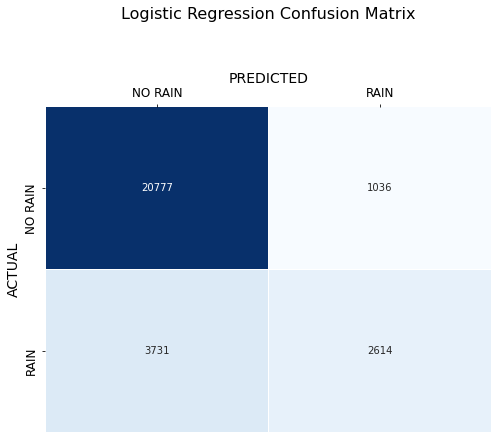

In [49]:
# Confusion matrix

cm = pd.DataFrame(confusion_matrix(y_test,y_lr_pred), index=['NO RAIN','RAIN'],columns=['NO RAIN','RAIN'])

print('Accuracy Score with 10 Features and 10 folds cross validation : {:.2%}'.format(accuracy_kfold),'\n')

# Plot CM
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(cm,annot=True,cbar=False, cmap='Blues',linewidths=.5,fmt='.0f')
ax.set_title('Logistic Regression Confusion Matrix',fontsize=16,y=1.25)
ax.set_ylabel('ACTUAL',fontsize=14)
ax.set_xlabel('PREDICTED',fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)

In [50]:
# Sensitivity and specifity

TP = cm.iloc[1,1] # True Positive - predicted "rain" correctly
TN = cm.iloc[0,0] # True Negative - predicted "no rain" correctly
FP = cm.iloc[0,1] # False Positive - predicted "rain" when it did not rain
FN = cm.iloc[1,0] # False Negative - predicted "no rain" when it rained

sens_lr = TP/(FN+TP)
spec_lr = TN/(FP+TN)

print('Sensitivity: {:.2%}'.format(sens_lr))
print('Specificity: {:.2%}'.format(spec_lr))

Sensitivity: 41.20%
Specificity: 95.25%


When it rained, we correctly predicted "rain" 41.20% of the time, whereas when it did not rain, we correctly predicted "no rain" 95.25% of the time. 

Although we noted it was not true, if we assume that the cost of a false positive is greater than the cost of a false negative, we may adjust the threshold rate to 22% (cf. 2.5.3). We expect the same phenomenon as with the random forest.

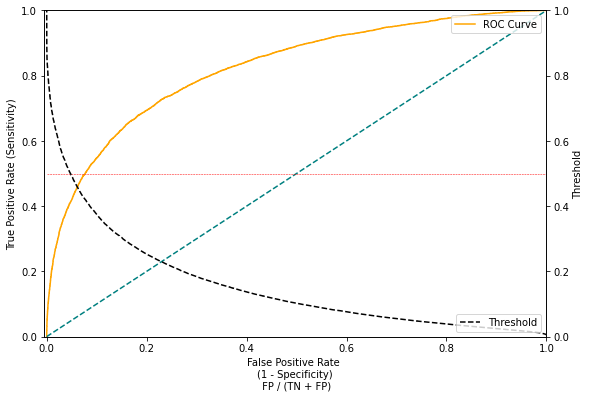

In [51]:
# ROC curve and threshold curve for the logistic regression model

# Probability of "rain" for X_test
y_prob_rain = lr.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_prob_rain[:,1])

# ROC curve
fig,ax1 = plt.subplots(figsize=(9,6))
ax1.plot(fpr, tpr,color='orange')
ax1.legend(['ROC Curve'],loc=1)
ax1.set_xlim([-.005, 1.])
ax1.set_ylim([0,1])
ax1.set_ylabel('True Positive Rate (Sensitivity)')
ax1.set_xlabel('False Positive Rate \n(1 - Specificity)\n FP / (TN + FP)')
#ax1.set_title('ROC Curve for RainTomorrow Logistic Regression Classifier\n')

plt.plot([0,1],[0,1],linestyle='--',color='teal')
plt.plot([0,1],[.5,.5],linestyle='--',color='red',linewidth=.5)

# threshold curve
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='black')
ax2.legend(['Threshold'],loc=4)
ax2.set_ylabel('Threshold',color='black')
ax2.set_ylim([0,1])
ax2.grid(False)



Accuracy score (top 10 features with 22% threshold): 75.24% 



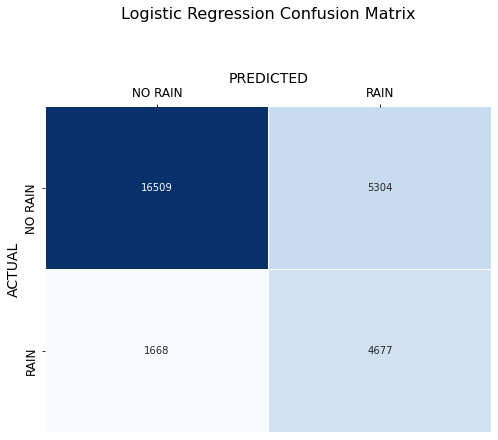

In [52]:
# Changing predictions using threshold rate of 22%
y_pred_class = binarize(y_prob_rain,threshold=chosen_threshold)[:,1]

cm = pd.DataFrame(confusion_matrix(y_test,y_pred_class), index=['NO RAIN','RAIN'],columns=['NO RAIN','RAIN'])

print('Accuracy score (top 10 features with 22% threshold): {:.2%}'.format(accuracy_score(y_test,y_pred_class)),'\n')

fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(cm,annot=True,cbar=False, cmap='Blues',linewidths=.5,fmt='.0f')
ax.set_title('Logistic Regression Confusion Matrix',fontsize=16,y=1.25)
ax.set_ylabel('ACTUAL',fontsize=14)
ax.set_xlabel('PREDICTED',fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)

In [53]:
TP = cm.iloc[1,1] # True Positive - predicted "rain" correctly
TN = cm.iloc[0,0] # True Negative - predicted "no rain" correctly
FP = cm.iloc[0,1] # False Positive - predicted "rain" when it did not rain
FN = cm.iloc[1,0] # False Negative - predicted "no rain" when it rained

sens_lr_2 = TP/(FN+TP)
spec_lr_2 = TN/(FP+TN)

print('Sensitivity: {:.2%}'.format(sens_lr_2))
print('Specificity: {:.2%}'.format(spec_lr_2))

Sensitivity: 73.71%
Specificity: 75.68%


When it rained, we correctly predicted "rain" 73.71% of the time, whereas when it did not rain, we correctly predicted "no rain" 75.68% of the time.

# 4. Comparison between random forest and logistic regression

The Area under the ROC curve (AUC) is an indicator of which model has the strongest performance.

In [54]:
lr_auc = cross_val_score(lr,X,y,cv=10,scoring='roc_auc').mean()

print('Null accuracy score: {:.2%}\n'.format(null_accuracy))
print('{:>30} {:>26}'.format('Random forest','Logistic regression'))
print('{} {:>17.2%} {:>22.2%}'.format('AUC score',rf_auc,lr_auc))
print('{} {:>14.2%} {:>22.2%}'.format('Sensitivity*',sens_rf,sens_lr))
print('{} {:>14.2%} {:>22.2%}'.format('Specificity*',spec_rf,spec_lr))
print('\n*50% threshold')

Null accuracy score: 77.47%

                 Random forest        Logistic regression
AUC score            85.90%                 82.28%
Sensitivity*         47.08%                 41.20%
Specificity*         95.34%                 95.25%

*50% threshold


**The random forest model is the better performer as the AUC is 85.90% vs. 82.28% for the logistic regression model.**

From comparing accuracy rates, the categorical features: *WindGustDir*, *WindDir9am* and *WindDir3pm*, offered little value. We saw the increase in the accuracy rates from having 1 feature to 59 and chose 10 features as that was the approximate point at which the increase in accuracy rate was very small. Having less features would simplify the model, reduce chances of overfitting, and provide better interpretability.

Both the random forest and the logistic regression had a low sensitivity rate which often incorrectly predicted that it won't rain the next day when it actually rained.

The ROC and threshold curves demonstrate the relationship between sensitivity and specificity at each threshold. Assuming that the cost of a false positive was greater than a false negative, we chose to reduce the threshold from 50% to 22%. This resulted in a decrease of the accuracy rate, thus our assumption proved to be incorrect. Whatsoever, we witnessed an increase of the sensitivity rate at the cost of a decrease of a specificity rate.

The features used in the random forest and logistic regression differ. Features used in the final models were:

| Random forest   | Logistic regression |
|:----------------|:--------------------|
| 1. Humidity3pm  | 1.  MinTemp         |
| 2. Pressure3pm  | 2.  MaxTemp         |
| 3. Pressure9am  | 3.  Rainfall        |
| 4. Humidity9am  | 4.  WindSpeed9am    |
| 5. Temp3pm      | 5.  Humidity3pm     |
| 6. MinTemp      | 6.  Pressure9am     |
| 7. MaxTemp      | 7.  Pressure3pm     |
| 7. Temp9am      | 8.  Temp9am         |
| 7. Rainfall     | 9.  Temp3pm         |
| 7. WindSpeed3pm | 10. RainToday       |